In [30]:
import xgboost
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn import metrics

In [6]:
df = pd.read_csv("train.csv", header=None)
label = pd.read_csv("trainLabels.csv", header=None)
print("Size of feature: {}\nSize of label: {}".format(df.shape, label.shape))

Size of feature: (1000, 40)
Size of label: (1000, 1)


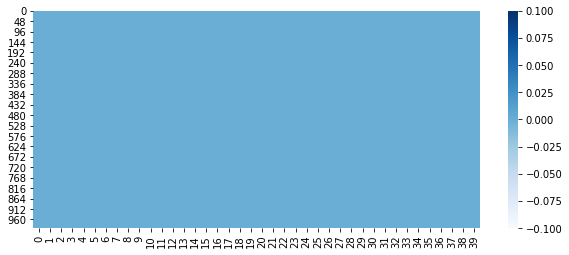

In [15]:
plt.figure(figsize=(10, 4))
sns.heatmap(df.isnull(), cmap="Blues")
plt.show()

In [34]:
df = StandardScaler().fit_transform(df)
x_train, x_test, y_train, y_test = train_test_split(df, label, test_size=0.25, random_state=17)

In [35]:
clf = xgboost.XGBClassifier(random_state=17)
n_estimators = [int(x) for x in np.linspace(100, 1000, 10)]
max_depth = [int(x) for x in np.linspace(5, 15, 10)]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth)
grid_search = GridSearchCV(clf, param_grid, scoring="accuracy", n_jobs=-1, verbose=0)
grid_result = grid_search.fit(x_train, y_train)
print("Best Accuracy: %.4f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best Accuracy: 0.8893 using {'max_depth': 6, 'n_estimators': 200}


C:\Users\YangWang\Anaconda3\envs\nlp\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\YangWang\Anaconda3\envs\nlp\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


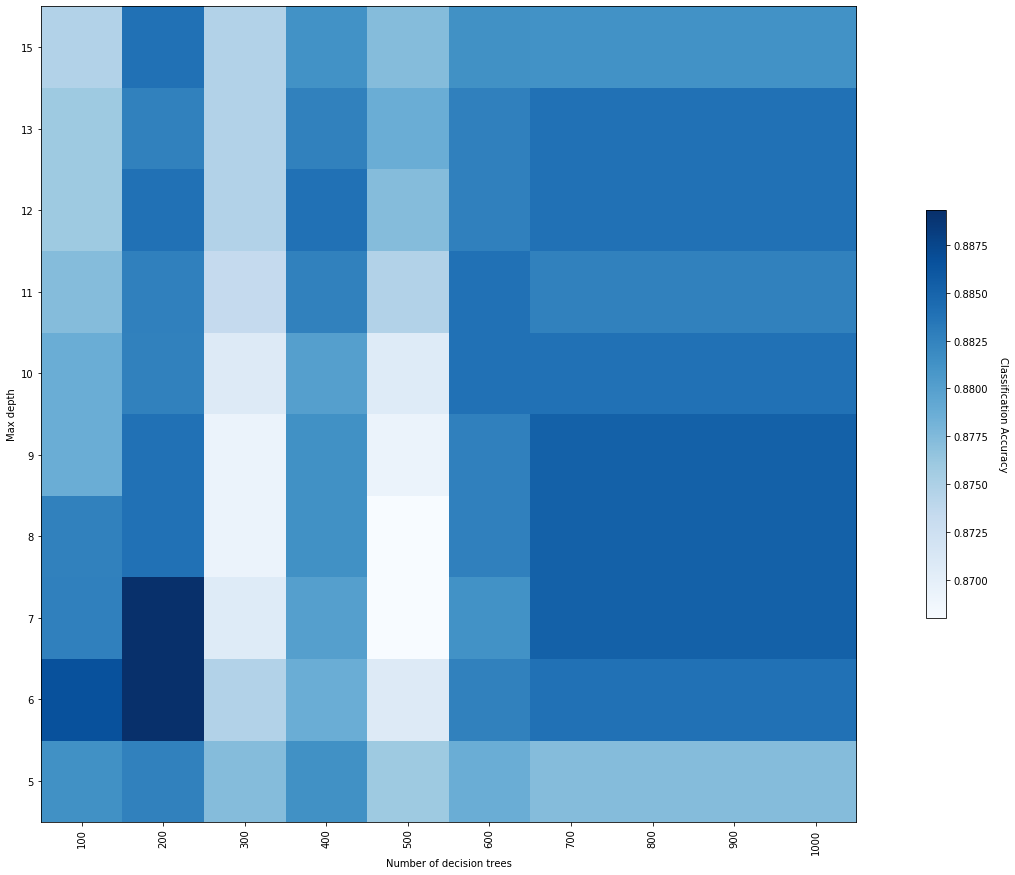

In [36]:
# Reference from 
# https://cambridgecoding.wordpress.com/2016/04/03/scanning-hyperspace-how-to-tune-machine-learning-models/
import matplotlib.pyplot as plt
%matplotlib inline
 
# Fetch scores, reshape into a grid
scores = [x for x in grid_result.cv_results_.get("mean_test_score")]
scores = np.array(scores).reshape(len(n_estimators), len(max_depth))
scores = np.transpose(scores)
 
# Make heatmap from grid search results
plt.figure(figsize=(25, 15))
plt.imshow(scores, interpolation='nearest', origin='higher', cmap='Blues')
plt.xticks(np.arange(len(n_estimators)), n_estimators)
plt.yticks(np.arange(len(max_depth)), max_depth)
plt.xlabel('Number of decision trees')
plt.ylabel('Max depth')
plt.xticks(rotation=90)
plt.colorbar(shrink=0.5).set_label('Classification Accuracy', rotation=270, labelpad=20)
plt.show()

In [37]:
# Train again using the best hyperparameters
clf_bestparam = xgboost.XGBClassifier(
    max_depth=grid_result.best_params_['max_depth'], 
    n_estimators=grid_result.best_params_['n_estimators'], 
    random_state=17)
clf_bestparam.fit(x_train, y_train)
y_pred = clf_bestparam.predict(x_test)
print("Accuracy: {:.4f}".format(metrics.accuracy_score(y_test, y_pred)))

Accuracy: 0.8200


In [45]:
x_test = pd.read_csv("test.csv", header=None)
x_test = StandardScaler().fit_transform(test)
y_pred = clf_bestparam.predict(x_test)
submit = pd.DataFrame(y_pred)
submit.index += 1
submit.columns = ['Solution']
submit['Id'] = np.arange(1, submit.shape[0]+1)
submit = submit[['Id', 'Solution']]
submit.to_csv('Submission.csv', index=False)